***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.1)** 32D>16D>8D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_3_1')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_1


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 20)          0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 100)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 20)           0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 20)          0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 20)           0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 8)           0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.4282 - prediction_coarse_accuracy: 0.4839 - prediction_medium_accuracy: 0.2756 - prediction_fine_accuracy: 0.0961
  • Coarse Accuracy = 48.39% | Val_Accuracy = 59.14% | LossWeight = 0.37 
  • Medium Accuracy = 27.56% | Val_Accuracy = 38.59% | LossWeight = 0.47 
  • Fine   Accuracy = 9.61% | Val_Accuracy = 16.71% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.16710, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_1\epoch-best.h5
781/781 [==============================] - 113s 134ms/step - loss: 0.4282 - prediction_coarse_accuracy: 0.4839 - prediction_medium_accuracy: 0.2756 - prediction_fine_accuracy: 0.0961 - val_loss: 0.3507 - val_prediction_coarse_accuracy: 0.5914 - val_prediction_medium_accuracy: 0.3859 - val_prediction_fine_accuracy: 0.1671 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3167 - prediction_coarse_accuracy: 0.6180

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1120 - prediction_coarse_accuracy: 0.9242 - prediction_medium_accuracy: 0.8880 - prediction_fine_accuracy: 0.7122
  • Coarse Accuracy = 92.42% | Val_Accuracy = 84.83% | LossWeight = 0.31 
  • Medium Accuracy = 88.80% | Val_Accuracy = 75.38% | LossWeight = 0.41 
  • Fine   Accuracy = 71.22% | Val_Accuracy = 61.20% | LossWeight = 0.28 

Epoch 18: val_prediction_fine_accuracy improved from 0.61040 to 0.61200, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_1\epoch-best.h5
781/781 [==============================] - 104s 133ms/step - loss: 0.1120 - prediction_coarse_accuracy: 0.9242 - prediction_medium_accuracy: 0.8880 - prediction_fine_accuracy: 0.7122 - val_loss: 0.1310 - val_prediction_coarse_accuracy: 0.8483 - val_prediction_medium_accuracy: 0.7538 - val_prediction_fine_accuracy: 0.6120 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1089 - prediction_coarse_accur

781/781 [==============================] - ETA: 0s - loss: 0.0947 - prediction_coarse_accuracy: 0.9450 - prediction_medium_accuracy: 0.9249 - prediction_fine_accuracy: 0.7890
  • Coarse Accuracy = 94.50% | Val_Accuracy = 85.71% | LossWeight = 0.32 
  • Medium Accuracy = 92.49% | Val_Accuracy = 76.68% | LossWeight = 0.39 
  • Fine   Accuracy = 78.90% | Val_Accuracy = 63.38% | LossWeight = 0.29 

Epoch 27: val_prediction_fine_accuracy improved from 0.63010 to 0.63380, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_1\epoch-best.h5
781/781 [==============================] - 104s 134ms/step - loss: 0.0947 - prediction_coarse_accuracy: 0.9450 - prediction_medium_accuracy: 0.9249 - prediction_fine_accuracy: 0.7890 - val_loss: 0.1267 - val_prediction_coarse_accuracy: 0.8571 - val_prediction_medium_accuracy: 0.7668 - val_prediction_fine_accuracy: 0.6338 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0931 - prediction_coarse_accuracy: 0.9450 -

781/781 [==============================] - 106s 135ms/step - loss: 0.0836 - prediction_coarse_accuracy: 0.9555 - prediction_medium_accuracy: 0.9439 - prediction_fine_accuracy: 0.8645 - val_loss: 0.1219 - val_prediction_coarse_accuracy: 0.8662 - val_prediction_medium_accuracy: 0.7804 - val_prediction_fine_accuracy: 0.6512 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0829 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9451 - prediction_fine_accuracy: 0.8660
  • Coarse Accuracy = 95.75% | Val_Accuracy = 86.36% | LossWeight = 0.35 
  • Medium Accuracy = 94.51% | Val_Accuracy = 77.87% | LossWeight = 0.40 
  • Fine   Accuracy = 86.60% | Val_Accuracy = 64.84% | LossWeight = 0.25 

Epoch 46: val_prediction_fine_accuracy did not improve from 0.65210
781/781 [==============================] - 107s 137ms/step - loss: 0.0829 - prediction_coarse_accuracy: 0.9575 - prediction_medium_accuracy: 0.9451 - prediction_fine_accuracy: 0.866

781/781 [==============================] - 107s 137ms/step - loss: 0.0813 - prediction_coarse_accuracy: 0.9596 - prediction_medium_accuracy: 0.9478 - prediction_fine_accuracy: 0.8917 - val_loss: 0.1226 - val_prediction_coarse_accuracy: 0.8673 - val_prediction_medium_accuracy: 0.7821 - val_prediction_fine_accuracy: 0.6539 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0794 - prediction_coarse_accuracy: 0.9595 - prediction_medium_accuracy: 0.9479 - prediction_fine_accuracy: 0.8933
  • Coarse Accuracy = 95.95% | Val_Accuracy = 86.64% | LossWeight = 0.36 
  • Medium Accuracy = 94.79% | Val_Accuracy = 78.52% | LossWeight = 0.42 
  • Fine   Accuracy = 89.33% | Val_Accuracy = 65.51% | LossWeight = 0.22 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.65680
781/781 [==============================] - 107s 137ms/step - loss: 0.0794 - prediction_coarse_accuracy: 0.9595 - prediction_medium_accuracy: 0.9479 - prediction_fine_accuracy: 0.893

Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0809 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 0.8972
  • Coarse Accuracy = 95.86% | Val_Accuracy = 86.67% | LossWeight = 0.37 
  • Medium Accuracy = 94.81% | Val_Accuracy = 78.45% | LossWeight = 0.42 
  • Fine   Accuracy = 89.72% | Val_Accuracy = 65.58% | LossWeight = 0.21 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.65850
781/781 [==============================] - 107s 137ms/step - loss: 0.0809 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 0.8972 - val_loss: 0.1221 - val_prediction_coarse_accuracy: 0.8667 - val_prediction_medium_accuracy: 0.7845 - val_prediction_fine_accuracy: 0.6558 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0806 - prediction_coarse_accuracy: 0.9595 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 

781/781 [==============================] - 107s 137ms/step - loss: 0.0798 - prediction_coarse_accuracy: 0.9588 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.9023 - val_loss: 0.1208 - val_prediction_coarse_accuracy: 0.8695 - val_prediction_medium_accuracy: 0.7872 - val_prediction_fine_accuracy: 0.6589 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0809 - prediction_coarse_accuracy: 0.9593 - prediction_medium_accuracy: 0.9490 - prediction_fine_accuracy: 0.9005
  • Coarse Accuracy = 95.93% | Val_Accuracy = 86.96% | LossWeight = 0.37 
  • Medium Accuracy = 94.90% | Val_Accuracy = 78.76% | LossWeight = 0.42 
  • Fine   Accuracy = 90.05% | Val_Accuracy = 66.12% | LossWeight = 0.21 

Epoch 93: val_prediction_fine_accuracy improved from 0.66080 to 0.66120, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_1\epoch-best.h5
781/781 [==============================] - 107s 137ms/step - loss: 0.0809 - prediction_coarse_accuracy: 

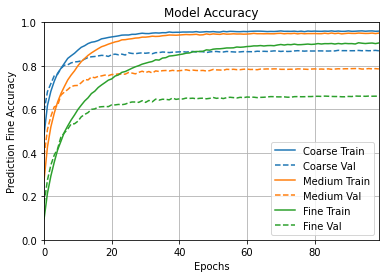

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

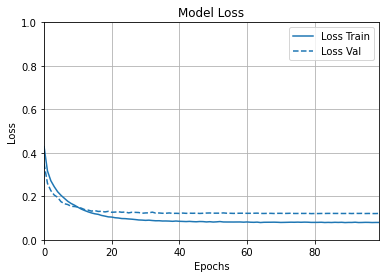

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 27ms/step - loss: 0.1632 - prediction_coarse_loss: 0.0987 - prediction_medium_loss: 0.1663 - prediction_fine_loss: 0.2746 - prediction_coarse_accuracy: 0.8692 - prediction_medium_accuracy: 0.7859 - prediction_fine_accuracy: 0.6602
1. loss ==> 0.16317935287952423
2. prediction_coarse_loss ==> 0.09865540266036987
3. prediction_medium_loss ==> 0.16629239916801453
4. prediction_fine_loss ==> 0.2746258080005646
5. prediction_coarse_accuracy ==> 0.8691999912261963
6. prediction_medium_accuracy ==> 0.7858999967575073
7. prediction_fine_accuracy ==> 0.6601999998092651
313/313 [==============================] - 7s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

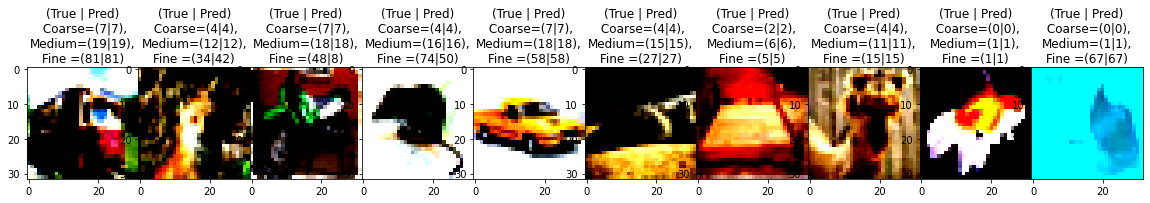

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 723   12   19   21  197    7    8   13]
 [  11 1359   35   29   36   23    1    6]
 [   6   19 1380   19   27    9   14   26]
 [  23   35   33  779  117    0    2   11]
 [  91   21   37   92 2221    8   11   19]
 [   8   22   24   11   28  888    0   19]
 [   1    7   12    9   37    0  431    3]
 [   9    1   26   12   19   21    1  911]]

  • MEDIUM LEVEL 
[[323  27   0   2   0   4   2   2  25   0   4  15  21  10   3  26  29   1
    3   3]
 [ 25 373   4   2   6   6   2   6   3   4   3   5   5   4   7  27   9   1
    3   5]
 [  0   4 450   4  18   3   2   6   1   1   2   0   1   3   2   2   0   1
    0   0]
 [  0   1   3 401  10  42   7   0   1   2   0   2   3   7   4   6   1   0
    3   7]
 [  3   1  16   9 426   9   1   3   5   1   1   1   2  11   1   5   4   0
    0   1]
 [  1   2   0  24   5 403  19   4   0   5   3   1   1   5  11   2   1   2
    6   5]
 [  0   3   0  10   2  18 439   4   2   4   1   0   1   1   5   2   1   1
    5   1]


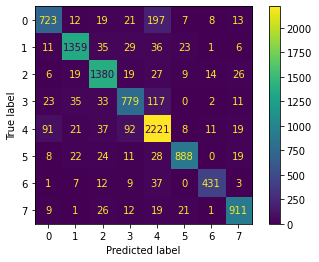

              precision    recall  f1-score   support

           0    0.82913   0.72300   0.77244      1000
           1    0.92073   0.90600   0.91331      1500
           2    0.88123   0.92000   0.90020      1500
           3    0.80144   0.77900   0.79006      1000
           4    0.82811   0.88840   0.85720      2500
           5    0.92887   0.88800   0.90798      1000
           6    0.92094   0.86200   0.89050       500
           7    0.90377   0.91100   0.90737      1000

    accuracy                        0.86920     10000
   macro avg    0.87678   0.85968   0.86738     10000
weighted avg    0.86969   0.86920   0.86863     10000


  • MEDIUM LEVEL 


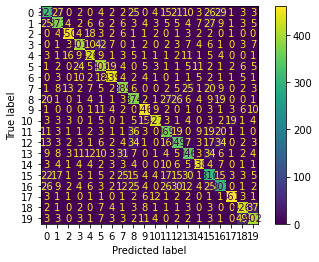

              precision    recall  f1-score   support

           0    0.68870   0.64600   0.66667       500
           1    0.79025   0.74600   0.76749       500
           2    0.90000   0.90000   0.90000       500
           3    0.82172   0.80200   0.81174       500
           4    0.83858   0.85200   0.84524       500
           5    0.73140   0.80600   0.76689       500
           6    0.87976   0.87800   0.87888       500
           7    0.77645   0.77800   0.77722       500
           8    0.68000   0.74800   0.71238       500
           9    0.86267   0.89200   0.87709       500
          10    0.90275   0.85400   0.87770       500
          11    0.73506   0.73800   0.73653       500
          12    0.70505   0.69800   0.70151       500
          13    0.71488   0.69200   0.70325       500
          14    0.88129   0.87600   0.87864       500
          15    0.59501   0.62000   0.60725       500
          16    0.65739   0.61400   0.63495       500
          17    0.93320   0

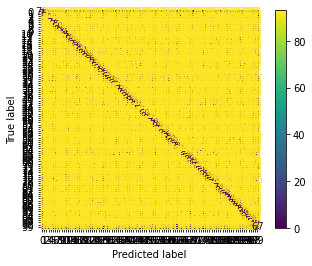

              precision    recall  f1-score   support

           0    0.81720   0.76000   0.78756       100
           1    0.77778   0.77000   0.77387       100
           2    0.49541   0.54000   0.51675       100
           3    0.55556   0.40000   0.46512       100
           4    0.50549   0.46000   0.48168       100
           5    0.65487   0.74000   0.69484       100
           6    0.80682   0.71000   0.75532       100
           7    0.66990   0.69000   0.67980       100
           8    0.85714   0.84000   0.84848       100
           9    0.86022   0.80000   0.82902       100
          10    0.57831   0.48000   0.52459       100
          11    0.50526   0.48000   0.49231       100
          12    0.69091   0.76000   0.72381       100
          13    0.64835   0.59000   0.61780       100
          14    0.59259   0.64000   0.61538       100
          15    0.60000   0.72000   0.65455       100
          16    0.69697   0.69000   0.69347       100
          17    0.86813   0

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7713966666666667 
Hierarchical Recall = 0.7922333333333332 
Hierarchical F1-Score = 0.7795511904761905 
Consistency =  0.8841 
Exact Match =  0.6293


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1124 - prediction_coarse_accuracy: 0.9250 - prediction_medium_accuracy: 0.8921 - prediction_fine_accuracy: 0.7999
  • Coarse Accuracy = 92.50% | Val_Accuracy = 83.82% | LossWeight = 0.34 
  • Medium Accuracy = 89.21% | Val_Accuracy = 74.51% | LossWeight = 0.44 
  • Fine   Accuracy = 79.99% | Val_Accuracy = 61.03% | LossWeight = 0.21 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.66120
781/781 [==============================] - 107s 137ms/step - loss: 0.1124 - prediction_coarse_accuracy: 0.9250 - prediction_medium_accuracy: 0.8921 - prediction_fine_accuracy: 0.7999 - val_loss: 0.1449 - val_prediction_coarse_accuracy: 0.8382 - val_prediction_medium_accuracy: 0.7451 - val_prediction_fine_accuracy: 0.6103 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1044 - prediction_coarse_accuracy: 0.9308 - prediction_medium_accuracy: 0.9036 - prediction_fine_accuracy: 0.8023


Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0967 - prediction_coarse_accuracy: 0.9386 - prediction_medium_accuracy: 0.9190 - prediction_fine_accuracy: 0.8347
  • Coarse Accuracy = 93.86% | Val_Accuracy = 84.49% | LossWeight = 0.36 
  • Medium Accuracy = 91.90% | Val_Accuracy = 75.31% | LossWeight = 0.42 
  • Fine   Accuracy = 83.47% | Val_Accuracy = 62.14% | LossWeight = 0.22 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.66120
781/781 [==============================] - 107s 137ms/step - loss: 0.0967 - prediction_coarse_accuracy: 0.9386 - prediction_medium_accuracy: 0.9190 - prediction_fine_accuracy: 0.8347 - val_loss: 0.1367 - val_prediction_coarse_accuracy: 0.8449 - val_prediction_medium_accuracy: 0.7531 - val_prediction_fine_accuracy: 0.6214 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0940 - prediction_coarse_accuracy: 0.9447 - prediction_medium_accuracy: 0.9253 - prediction_fine_accuracy: 0.84

781/781 [==============================] - 107s 137ms/step - loss: 0.0860 - prediction_coarse_accuracy: 0.9512 - prediction_medium_accuracy: 0.9379 - prediction_fine_accuracy: 0.8833 - val_loss: 0.1275 - val_prediction_coarse_accuracy: 0.8590 - val_prediction_medium_accuracy: 0.7744 - val_prediction_fine_accuracy: 0.6389 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0854 - prediction_coarse_accuracy: 0.9554 - prediction_medium_accuracy: 0.9395 - prediction_fine_accuracy: 0.8870
  • Coarse Accuracy = 95.54% | Val_Accuracy = 86.17% | LossWeight = 0.36 
  • Medium Accuracy = 93.95% | Val_Accuracy = 77.38% | LossWeight = 0.43 
  • Fine   Accuracy = 88.70% | Val_Accuracy = 63.80% | LossWeight = 0.21 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.66120
781/781 [==============================] - 107s 137ms/step - loss: 0.0854 - prediction_coarse_accuracy: 0.9554 - prediction_medium_accuracy: 0.9395 - prediction_fine_accuracy: 0.887

781/781 [==============================] - 107s 137ms/step - loss: 0.0788 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9497 - prediction_fine_accuracy: 0.9215 - val_loss: 0.1218 - val_prediction_coarse_accuracy: 0.8670 - val_prediction_medium_accuracy: 0.7875 - val_prediction_fine_accuracy: 0.6570 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0787 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9507 - prediction_fine_accuracy: 0.9235
  • Coarse Accuracy = 96.04% | Val_Accuracy = 86.69% | LossWeight = 0.39 
  • Medium Accuracy = 95.07% | Val_Accuracy = 78.74% | LossWeight = 0.44 
  • Fine   Accuracy = 92.35% | Val_Accuracy = 65.90% | LossWeight = 0.18 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.66120
781/781 [==============================] - 107s 137ms/step - loss: 0.0787 - prediction_coarse_accuracy: 0.9604 - prediction_medium_accuracy: 0.9507 - prediction_fine_accuracy: 0.923

Epoch 48/100
781/781 [==============================] - ETA: 0s - loss: 0.0777 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.9292
  • Coarse Accuracy = 96.14% | Val_Accuracy = 86.80% | LossWeight = 0.40 
  • Medium Accuracy = 95.27% | Val_Accuracy = 78.91% | LossWeight = 0.44 
  • Fine   Accuracy = 92.92% | Val_Accuracy = 65.83% | LossWeight = 0.17 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.66260
781/781 [==============================] - 107s 137ms/step - loss: 0.0777 - prediction_coarse_accuracy: 0.9614 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.9292 - val_loss: 0.1205 - val_prediction_coarse_accuracy: 0.8680 - val_prediction_medium_accuracy: 0.7891 - val_prediction_fine_accuracy: 0.6583 - lr: 1.4240e-04
Epoch 49/100
781/781 [==============================] - ETA: 0s - loss: 0.0774 - prediction_coarse_accuracy: 0.9616 - prediction_medium_accuracy: 0.9514 - prediction_fine_accuracy: 

781/781 [==============================] - 107s 137ms/step - loss: 0.0776 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9522 - prediction_fine_accuracy: 0.9301 - val_loss: 0.1197 - val_prediction_coarse_accuracy: 0.8697 - val_prediction_medium_accuracy: 0.7926 - val_prediction_fine_accuracy: 0.6618 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0775 - prediction_coarse_accuracy: 0.9626 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.9329
  • Coarse Accuracy = 96.26% | Val_Accuracy = 87.05% | LossWeight = 0.39 
  • Medium Accuracy = 95.29% | Val_Accuracy = 79.09% | LossWeight = 0.44 
  • Fine   Accuracy = 93.29% | Val_Accuracy = 66.26% | LossWeight = 0.16 

Epoch 58: val_prediction_fine_accuracy did not improve from 0.66340
781/781 [==============================] - 107s 137ms/step - loss: 0.0775 - prediction_coarse_accuracy: 0.9626 - prediction_medium_accuracy: 0.9529 - prediction_fine_accuracy: 0.932

781/781 [==============================] - 107s 137ms/step - loss: 0.0763 - prediction_coarse_accuracy: 0.9641 - prediction_medium_accuracy: 0.9557 - prediction_fine_accuracy: 0.9356 - val_loss: 0.1186 - val_prediction_coarse_accuracy: 0.8694 - val_prediction_medium_accuracy: 0.7931 - val_prediction_fine_accuracy: 0.6643 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0758 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9539 - prediction_fine_accuracy: 0.9352
  • Coarse Accuracy = 96.25% | Val_Accuracy = 86.85% | LossWeight = 0.40 
  • Medium Accuracy = 95.39% | Val_Accuracy = 79.17% | LossWeight = 0.44 
  • Fine   Accuracy = 93.52% | Val_Accuracy = 66.40% | LossWeight = 0.16 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.66450
781/781 [==============================] - 107s 137ms/step - loss: 0.0758 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9539 - prediction_fine_accuracy: 0.935

Epoch 86/100
781/781 [==============================] - ETA: 0s - loss: 0.0763 - prediction_coarse_accuracy: 0.9628 - prediction_medium_accuracy: 0.9540 - prediction_fine_accuracy: 0.9356
  • Coarse Accuracy = 96.28% | Val_Accuracy = 86.98% | LossWeight = 0.40 
  • Medium Accuracy = 95.40% | Val_Accuracy = 79.38% | LossWeight = 0.44 
  • Fine   Accuracy = 93.56% | Val_Accuracy = 66.44% | LossWeight = 0.16 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.66630
781/781 [==============================] - 107s 137ms/step - loss: 0.0763 - prediction_coarse_accuracy: 0.9628 - prediction_medium_accuracy: 0.9540 - prediction_fine_accuracy: 0.9356 - val_loss: 0.1187 - val_prediction_coarse_accuracy: 0.8698 - val_prediction_medium_accuracy: 0.7938 - val_prediction_fine_accuracy: 0.6644 - lr: 2.0277e-05
Epoch 87/100
781/781 [==============================] - ETA: 0s - loss: 0.0772 - prediction_coarse_accuracy: 0.9622 - prediction_medium_accuracy: 0.9534 - prediction_fine_accuracy: 

781/781 [==============================] - 107s 137ms/step - loss: 0.0767 - prediction_coarse_accuracy: 0.9640 - prediction_medium_accuracy: 0.9539 - prediction_fine_accuracy: 0.9345 - val_loss: 0.1188 - val_prediction_coarse_accuracy: 0.8690 - val_prediction_medium_accuracy: 0.7926 - val_prediction_fine_accuracy: 0.6638 - lr: 1.2779e-05
Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0766 - prediction_coarse_accuracy: 0.9622 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.9337
  • Coarse Accuracy = 96.22% | Val_Accuracy = 86.92% | LossWeight = 0.39 
  • Medium Accuracy = 95.27% | Val_Accuracy = 79.28% | LossWeight = 0.44 
  • Fine   Accuracy = 93.37% | Val_Accuracy = 66.36% | LossWeight = 0.16 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.66630
781/781 [==============================] - 107s 137ms/step - loss: 0.0766 - prediction_coarse_accuracy: 0.9622 - prediction_medium_accuracy: 0.9527 - prediction_fine_accuracy: 0.933

In [24]:
history_dict = history.history

(0.0, 1.0)

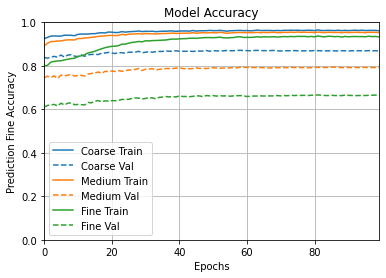

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

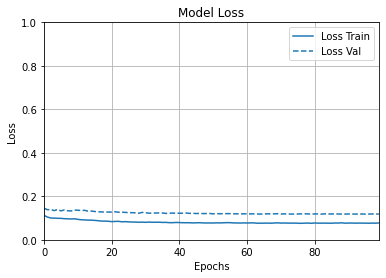

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 10s 27ms/step - loss: 0.1512 - prediction_coarse_loss: 0.0953 - prediction_medium_loss: 0.1569 - prediction_fine_loss: 0.2737 - prediction_coarse_accuracy: 0.8693 - prediction_medium_accuracy: 0.7931 - prediction_fine_accuracy: 0.6638
1. loss ==> 0.15116655826568604
2. prediction_coarse_loss ==> 0.09529387205839157
3. prediction_medium_loss ==> 0.15685728192329407
4. prediction_fine_loss ==> 0.2737105190753937
5. prediction_coarse_accuracy ==> 0.8693000078201294
6. prediction_medium_accuracy ==> 0.7930999994277954
7. prediction_fine_accuracy ==> 0.6638000011444092
313/313 [==============================] - 7s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

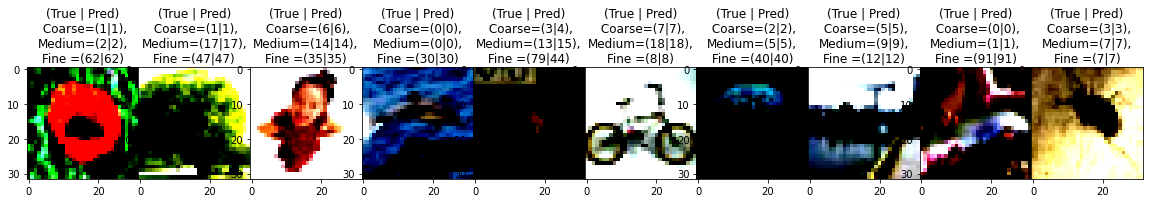

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 717   14   20   23  193   13   10   10]
 [   8 1370   28   31   39   18    1    5]
 [   8   24 1366   18   33   11    9   31]
 [  22   36   28  799  103    1    1   10]
 [  94   18   44   81 2221   12   14   16]
 [   9   19   23    6   24  894    1   24]
 [   0    7   15   11   40    2  421    4]
 [   7    4   31    9   23   21    0  905]]

  • MEDIUM LEVEL 
[[310  31   0   1   0   4   3   2  24   2   3  15  31  14   5  20  27   3
    2   3]
 [ 25 375   6   5   6   5   1   4   4   3   4   6   6   6   7  18  12   0
    3   4]
 [  0   5 447   5  18   1   1  10   0   1   1   1   1   3   2   2   1   1
    0   0]
 [  0   2   4 403   9  40   6   1   1   4   0   1   4   6   3   5   0   0
    3   8]
 [  1   2  20   9 421   6   0   4   5   0   1   4   4  14   1   4   3   1
    0   0]
 [  2   2   2  28   6 395  20   3   0   6   2   3   0   7   7   2   0   3
    2  10]
 [  2   3   1  10   2  24 433   0   1   1   1   1   2   4   3   2   0   1
    5   4]


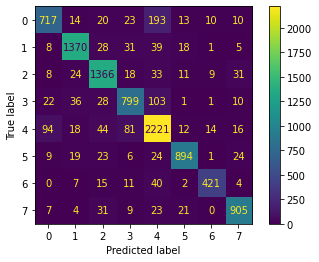

              precision    recall  f1-score   support

           0    0.82890   0.71700   0.76890      1000
           1    0.91823   0.91333   0.91578      1500
           2    0.87846   0.91067   0.89427      1500
           3    0.81697   0.79900   0.80789      1000
           4    0.82997   0.88840   0.85819      2500
           5    0.91975   0.89400   0.90669      1000
           6    0.92123   0.84200   0.87983       500
           7    0.90050   0.90500   0.90274      1000

    accuracy                        0.86930     10000
   macro avg    0.87675   0.85867   0.86679     10000
weighted avg    0.86967   0.86930   0.86867     10000


  • MEDIUM LEVEL 


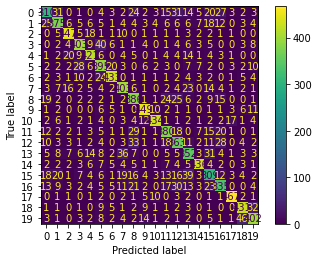

              precision    recall  f1-score   support

           0    0.72261   0.62000   0.66738       500
           1    0.77479   0.75000   0.76220       500
           2    0.86628   0.89400   0.87992       500
           3    0.82077   0.80600   0.81332       500
           4    0.83202   0.84200   0.83698       500
           5    0.72477   0.79000   0.75598       500
           6    0.87830   0.86600   0.87210       500
           7    0.78405   0.80600   0.79487       500
           8    0.70567   0.77200   0.73734       500
           9    0.86847   0.89800   0.88299       500
          10    0.91368   0.86800   0.89026       500
          11    0.75547   0.76000   0.75773       500
          12    0.69674   0.72600   0.71107       500
          13    0.68616   0.70400   0.69497       500
          14    0.89897   0.87200   0.88528       500
          15    0.64509   0.61800   0.63126       500
          16    0.71581   0.67000   0.69215       500
          17    0.92843   0

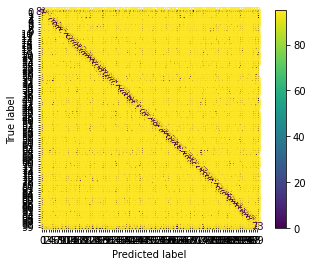

              precision    recall  f1-score   support

           0    0.89011   0.81000   0.84817       100
           1    0.82222   0.74000   0.77895       100
           2    0.51456   0.53000   0.52217       100
           3    0.51111   0.46000   0.48421       100
           4    0.51852   0.42000   0.46409       100
           5    0.69388   0.68000   0.68687       100
           6    0.73118   0.68000   0.70466       100
           7    0.65741   0.71000   0.68269       100
           8    0.84375   0.81000   0.82653       100
           9    0.81915   0.77000   0.79381       100
          10    0.59783   0.55000   0.57292       100
          11    0.44186   0.38000   0.40860       100
          12    0.70909   0.78000   0.74286       100
          13    0.59140   0.55000   0.56995       100
          14    0.58475   0.69000   0.63303       100
          15    0.58772   0.67000   0.62617       100
          16    0.68687   0.68000   0.68342       100
          17    0.85263   0

In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7742516666666667 
Hierarchical Recall = 0.7919666666666666 
Hierarchical F1-Score = 0.7811896825396826 
Consistency =  0.898 
Exact Match =  0.638
